# WhatsApp Chat Humor Analyzer

### Determine who is the funniest - with data!

By Duncan Bell

WhatsApp is a great tool for friends to keep in touch and stay close.  And if you're friends are like mine, there'a always a lot of laughter.  But who among your friend group is the funniest?  Let's find out.

This program requires a WhatsApp chat export from the [Backup WhatsApp Chats](https://chrome.google.com/webstore/detail/backup-whatsapp-chats/gmbicfpadlmgkfhfepknbmemfhahelll?hl=en) Chrome extension.  This code will require configuration if you use some other tool to export as data will be structured differently.

### How it works

How can we measure how funny someone is?  By how much laughter they cause!  That's where we start: identifying laughter.  Chats are flagged as containing laughter by performing keyword searches for known laughter terms (LOL, haha, 😂, etc.).  That's the easy part.  Next we need to determine who caused the laughter.  

To link laughter to its originating 'joke' in an automated way, we need to look at the preceding chats and consider some rules:

1. Is the laugher responding to a quoted message?  If so - you're done!  Easy one!
2. Is the chatter == the laugher?  If so, keep looking.  
3. Does the chat also contain laughter?  If so, keep looking.



In [1]:
import pandas as pd
import numpy as np
#from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import dateutil.parser
from datetime import date

#plt.rcParams['figure.figsize'] = (5, 3)

%matplotlib inline

In [2]:
#run this code first to update the laugh words lookup table

#chat = pd.read_csv('Fantasy Babymakers 9.2014-3.2020.csv') #chat for humor assessment
chat = pd.read_csv('Beware of Trolls 7.2018-3.2020.csv') #chat for humor assessment
#chat = pd.read_csv('Private pics - 3.2020.csv')
#chat = pd.read_csv('Duddles -3.20.csv')

laughs = pd.read_csv('funny_words_utf.csv')
laughs_lower=[] #making sure we have lowercase in funny_words
for laugh in laughs.funny:
    laughs_lower.append(str(laugh).lower())
laughs['funny'] = laughs_lower

exclusions=['https://twitter.com/hahatimbridge/status/1242949373652357124']
new_laugh_words =[]
new_laugh_words_consider =[]
for item in chat.MessageBody:
    if isinstance(item, str) is True:
        for word in item.split():
            word = str(word).lower()
            if ('ahah' in word or 'haha' in word or 'hha' in word) and word not in list(laughs.funny) and word not in exclusions:
                new_laugh_words.append(word)
            if ('aha' in word or 'hah' in word or 'lmao' in word or 'rofl' in word) and word not in list(laughs.funny) and word not in new_laugh_words:
                new_laugh_words_consider.append(word)

for item in set(new_laugh_words):
    if len(item) <=5:
        laughs = pd.concat([laughs,pd.DataFrame({'funny':item,'value':[1]})],)
    if len(item) ==6:
        laughs = pd.concat([laughs,pd.DataFrame({'funny':item,'value':[1.5]})])
    if len(item) >=7:
        laughs = pd.concat([laughs,pd.DataFrame({'funny':item,'value':[2]})])

laughs.to_csv('funny_words_utf.csv',index=False)

print('laugh words added:')
print(set(new_laugh_words))
print('consider adding these laugh words:')
print(set(new_laugh_words_consider))

laugh words added:
set()
consider adding these laugh words:
{'https://twitter.com/hahatimbridge/status/1242949373652357124', 'shahs', 'tomahawk'}


In [3]:
laughs = pd.read_csv('funny_words_utf.csv')

chat.dropna(axis=0,subset=['MessageBody','UserName'],inplace=True) #get rid of any chats without message or username
chat.reset_index(inplace=True)

#dictionary for looking up laughter weight value
laughs_dict = {}
for laugh, value in zip(laughs['funny'],laughs['value']):
    laughs_dict.update( {laugh : value} )

#marking messages that contain laughter
laugh = []
for message, media in zip(chat.MessageBody,chat.MediaType):
    if isinstance(message,float) is False:
        message_laughs = 0
        if (isinstance(media,float) is True) | (media == 'Text'):
            message=str(message).lower()
            for word in message.split():
                if (word in list(laughs.funny)) | ('😂' in word) | ('🤣' in word) | ('😆' in word):
                    message_laughs = message_laughs + 1
            if ('losing it' in message) | ('lost it' in message) | ('m dying' in message): #some laughter is multiple words
                message_laughs = message_laughs + 1
            if message_laughs > 0:
                laugh.append(1)
            else:
                laugh.append(0)
        else:
            laugh.append(0)
    else:
        laugh.append(0)
chat['laugh'] = laugh

#weighting laughs according to the severity
max_weights=[]
for message,laugh in zip(chat.MessageBody,chat.laugh):
    if laugh == 1:
        laugh_weights = []
        message=str(message).lower()
        for word in message.split():
            if word in list(laughs.funny):
                laugh_weights.append(laughs_dict[word])
            if ('😂' in word) | ('🤣' in word) | ('😆' in word):
                laugh_weights.append(1.5)
        if ('losing it' in message) | ('lost it' in message) | ('m dying' in message): #for 'i'm losing it' and 'i'm dying'
            laugh_weights.append(2)
        if len(laugh_weights) == 0:
            laugh_weights.append(1) #if for some reason this falls through the cracks, we assign weight of 1
        laugh_weights.sort(reverse=True)
        max_weights.append(laugh_weights[0]) #take the highest laugh weight available within the message
    else:
        max_weights.append(0)
chat['laugh_weight'] = max_weights

#splitting date into month, day, year
months = []
days = []
years = []
for date in chat.Date2:
    d = dateutil.parser.parse(date).date()
    months.append(str(d.month))
    days.append(str(d.day))
    years.append(str(d.year))
chat['month'] = months
chat['day'] = days
chat['year'] = years
chat['year_month'] = chat.year + '_' + chat.month

#now creating a dataframe containing jokers, their messages, laughers, their messages
jokes = []
for row in chat[chat.laugh == 1].index:
    c=0
    laugher = chat.iloc[row].UserName
    date = chat.iloc[row].Date2
    ym = chat.iloc[row].year_month
    if isinstance(chat.iloc[row].QuotedMessage,float) is False: #handle if laughter is directed at quoted message
        joker = chat.iloc[chat[(chat.Date2 == chat.iloc[row].QuotedMessageDate) & (chat.Time == chat.iloc[row].QuotedMessageTime)].index[0]].UserName
        jokes.append((date,ym,joker,chat.iloc[chat[(chat.Date2 == chat.iloc[row].QuotedMessageDate) & (chat.Time == chat.iloc[row].QuotedMessageTime)].index[0]].MessageBody,laugher,chat.iloc[row].MessageBody,chat.iloc[row].laugh_weight))
        c=1
    elif row > 9: #excluding first 10 rows
        r=0
        for prev_row in range(row-1,row-11,-1): #searching previous 10 chats for joker
            r=r+1
            if c == 0:
                if (isinstance(chat.iloc[prev_row].MediaType,float) is False) & (chat.iloc[prev_row].MediaType != 'Text') & (chat.iloc[prev_row].UserName != laugher): #handle people sharing photos, media
                    joker = chat.iloc[prev_row].UserName
                    jokes.append((date,ym,joker,chat.iloc[prev_row].MessageBody,laugher,chat.iloc[row].MessageBody,chat.iloc[row].laugh_weight))
                    c=1
                elif (chat.iloc[prev_row].laugh == 0) & (chat.iloc[prev_row].UserName != laugher):
                    joker = chat.iloc[prev_row].UserName
                    jokes.append((date,ym,joker,chat.iloc[prev_row].MessageBody,laugher,chat.iloc[row].MessageBody,chat.iloc[row].laugh_weight))
                    c=1
            elif (r == 10) & (c == 0): #if no jokers identified even after 10 previous rows, we append laugh only
                jokes.append((date,ym,'','',laugher,chat.iloc[row].MessageBody,chat.iloc[row].laugh_weight))
    #else: #control for first 10 rows
    #    jokes.append((date,'','',laugher,chat.iloc[row].MessageBody,chat.iloc[row].laugh_weight))
        
jokes_df = pd.DataFrame(jokes,columns=['date','year_month','joker','joke_message','laugher','laugh_message','laugh_weight'])

#now creating summary figures to assess jokers
joker_counts = pd.DataFrame(jokes_df.joker.value_counts())
laugher_counts = pd.DataFrame(jokes_df.laugher.value_counts())
full_chat_counts = pd.DataFrame(chat.UserName.value_counts())
full_chat_counts.rename(columns={"UserName": "full_chat_count"},inplace=True)
aggregations = {
    'laugh_weight': 'sum'
}

joker_weights = jokes_df.groupby(by=['joker']).agg({'laugh_weight': 'sum'})

Summary = pd.concat([joker_counts,laugher_counts,full_chat_counts,joker_weights],axis=1)
Summary.reset_index(inplace=True)
Summary.rename(columns={'joker':'joke_count','index':'joker','laugher':'laugh_count'},inplace=True)
Summary=Summary.fillna(0)

Summary['joke_proportion'] = Summary.joke_count / (Summary.full_chat_count - Summary.laugh_count)
#Summary['weighted_laugh_proportion'] = Summary.laugh_weight / (Summary.full_chat_count - Summary.laugher)

#we will use this to assess joke distribution among chatters, could also be used as a composite metric as well
joke_count_z_scores = []
for joker,i in zip(Summary.joker, list(range(Summary.shape[0]))):
    joke_count_z_scores.append((Summary[Summary.joker == joker].joke_count[i] - Summary.joke_count.mean()) / float(Summary.joke_count.std()))
Summary['joke_count_z_score'] = joke_count_z_scores

#building a feature which describes "how spread out the laugher is" among chatters
laugher_proportions = []
for joker in jokes_df.joker.drop_duplicates():
    for laugher in jokes_df.laugher.drop_duplicates():
        if laugher != joker:
            laugher_proportions.append((joker,laugher,jokes_df[(jokes_df.joker == joker) & (jokes_df.laugher == laugher)].shape[0]\
                                           / jokes_df[jokes_df.laugher == laugher].shape[0]))

laugher_proportions_df = pd.DataFrame(data=laugher_proportions,columns=['joker','laugher','laugher_proportion'])
laugher_proportions_df.sort_values(by=['joker','laugher_proportion'], ascending=False) #these are not directly used for scoring

from statistics import mean

laugh_distribution_scores = []
laugher_distribution_dfs =[]
for joker in Summary.joker:
    laugher_distribution_z_scores =[]
    for laugher in laugher_proportions_df.laugher.drop_duplicates():
        if joker != laugher:
            #this is a score to indicate a laugher's laughs for given joker relative to the number of laughs for given laugher
            #point is to get at whether a joker is getting laughs from everyone or just a small number of people
            try:
                laugher_distribution_z_score = ((list(laugher_proportions_df[(laugher_proportions_df.joker == joker) & (laugher_proportions_df.laugher == laugher)].laugher_proportion)[0]\
                                                - laugher_proportions_df[laugher_proportions_df.laugher == laugher].laugher_proportion.mean())\
                                                / float(laugher_proportions_df[laugher_proportions_df.laugher == laugher].laugher_proportion.std()))
            except:
                laugher_distribution_z_score.append(0)
            laugher_distribution_z_scores.append((joker,laugher,laugher_distribution_z_score))
            laugher_distribution_z_scores_df=pd.DataFrame(laugher_distribution_z_scores,columns=['joker','laugher','laugher_distribution_z_score'])
    comparison_scores = []
    for index, row in laugher_distribution_z_scores_df.iterrows():
        #we compare the joke count z score to these laugher distribution scores and then take mean
        #this is to even the playing field between jokers that joke a lot vs a little, because our interest is not in them but their laughers
        comparison_scores.append((row['laugher_distribution_z_score'] + 3) - (list(Summary[Summary.joker == joker].joke_count_z_score)[0] + 3))
    laugher_distribution_z_scores_df['comparison_score'] = comparison_scores
    laugher_distribution_dfs.append(laugher_distribution_z_scores_df)
    laugh_distribution_scores.append(mean(comparison_scores)+1)
laugher_distribution_full_df = pd.concat(laugher_distribution_dfs)

Summary['laugh_distribution_score'] = laugh_distribution_scores

#creating a metric to credit jokers who make multiple people laugh
big_joke_counts = []
for joker in Summary.joker:
    joker_df = jokes_df[jokes_df.joker == joker]
    joker_df_counts = pd.DataFrame(joker_df.joke_message.value_counts())
    big_joke_counts.append(joker_df_counts[joker_df_counts.joke_message >= 2].shape[0]) #count number of jokes having at least 2 laughs
Summary['big_joke_count'] = big_joke_counts

#creating the z scores that we'll use for composite score

weighted_laughs_z_scores = []
for value in Summary.laugh_weight:
    weighted_laughs_z_scores.append(((value - Summary.laugh_weight.mean()) / Summary.laugh_weight.std())+3)
    
Summary['weighted_laughs_z_score'] = weighted_laughs_z_scores #based on amount of laughter elicited, weighted by size of laugh

joke_proportion_z_scores = []
for value in Summary.joke_proportion:
    joke_proportion_z_scores.append(((value - Summary.joke_proportion.mean()) / Summary.joke_proportion.std())+3)
    
Summary['joke_proportion_z_score'] = joke_proportion_z_scores #what proportion of total chats were jokes?

laugh_distribution_z_scores = []
for value in Summary.laugh_distribution_score:
    laugh_distribution_z_scores.append(((value - Summary.laugh_distribution_score.mean()) / Summary.laugh_distribution_score.std())+3)
    
Summary['laugh_distribution_z_score'] = laugh_distribution_z_scores #did your jokes have broad or narrow appeal amongst chatters?

big_joke_z_scores = []
for value in Summary.big_joke_count:
    big_joke_z_scores.append(((value - Summary.big_joke_count.mean()) / Summary.big_joke_count.std())+3)
    
Summary['big_joke_z_score'] = big_joke_z_scores #how often do you make multiple people laugh

#all metrics weighted evenly
Summary['composite_humor_score'] = (Summary['weighted_laughs_z_score'] + Summary['big_joke_z_score'] + Summary['joke_proportion_z_score'] + Summary['laugh_distribution_z_score']) / 4
Summary.sort_values(by=['composite_humor_score'],ascending=False,inplace=True)
Summary

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,joker,joke_count,laugh_count,full_chat_count,laugh_weight,joke_proportion,joke_count_z_score,laugh_distribution_score,big_joke_count,weighted_laughs_z_score,joke_proportion_z_score,laugh_distribution_z_score,big_joke_z_score,composite_humor_score
7,Krista Gunter,246,145,2115,342.5,0.124873,1.679633,0.749758,34,4.600050,4.363919,1.790040,5.285889,4.009974
8,Mark Casstevens,225,304,2265,319.0,0.114737,1.429602,0.971503,25,4.404174,3.971610,2.862214,4.371533,3.902383
11,Sarah Casstevens,61,43,465,88.0,0.144550,-0.523025,1.044446,11,2.478756,5.125516,3.214904,2.949202,3.442095
10,Patrick Deane,211,212,2868,315.5,0.079443,1.262914,0.726293,20,4.375001,2.605510,1.676584,3.863558,3.130163
4,Francesca Deane,69,106,725,98.5,0.111470,-0.427775,1.085629,8,2.566275,3.845148,3.414032,2.644417,3.117468
3,Duncan Bell,92,87,1238,131.5,0.079930,-0.153931,0.978560,14,2.841335,2.624388,2.896332,3.253988,2.904011
13,Scott Gunter,228,135,3002,323.5,0.079526,1.465320,0.566440,17,4.441682,2.608718,0.903669,3.558773,2.878210
0,Ben Deane,102,97,1349,151.0,0.081470,-0.034868,0.963243,10,3.003870,2.683962,2.822275,2.847607,2.839429
9,Michael Waidmann,40,31,488,55.0,0.087527,-0.773056,1.228901,2,2.203696,2.918429,4.106773,2.034847,2.815936
6,Kevin Jellerson,46,46,525,71.5,0.096033,-0.701619,1.063864,5,2.341226,3.247661,3.308793,2.339632,2.809328


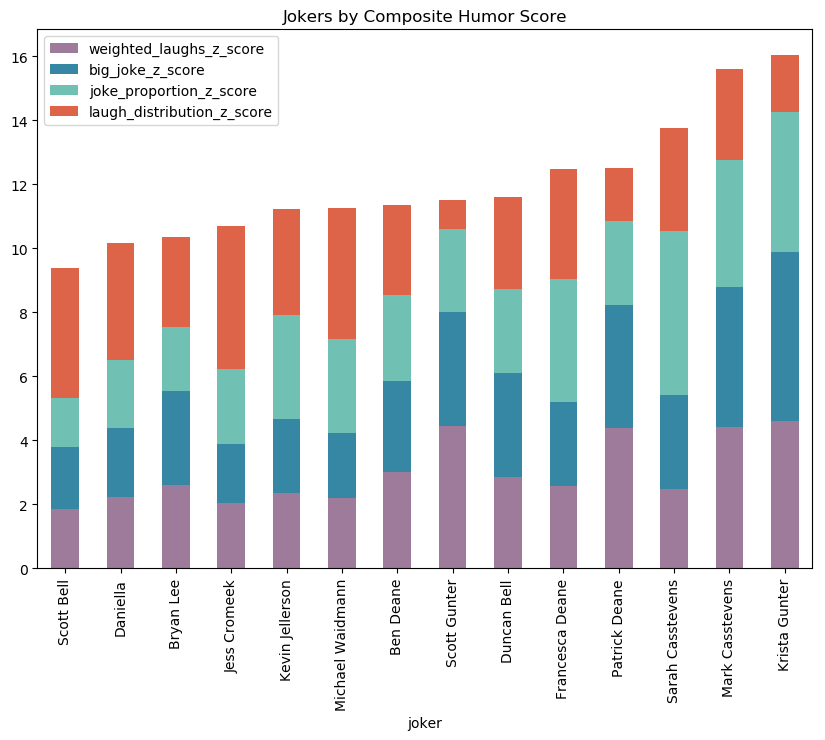

In [4]:
#Chat members ranked by composite humor score, stacked bar

matplotlib.style.use('default')#('ggplot')

metrics=['weighted_laughs_z_score','big_joke_z_score','joke_proportion_z_score','laugh_distribution_z_score']
jokers=[]
metric_labels=[]
values=[]
Summary_stacked_bar=Summary.sort_values(by=['composite_humor_score'])
for joker in Summary_stacked_bar.joker:
    for metric in metrics:
        jokers.append(joker)
        metric_labels.append(metric)
        values.append(list(Summary[Summary.joker==joker][metric])[0])
data = [jokers,metric_labels,values]

rows = zip(data[0], data[1], data[2])
headers = ['joker', 'metric', 'score']
df = pd.DataFrame(rows, columns=headers)

fig, ax = plt.subplots(figsize=(10,7))  

margin_bottom = np.zeros(len(df['joker'].drop_duplicates()))
colors = ["#9E7B9B","#3587A4","#70C1B3","#DE6449"]

for num, metric in enumerate(metrics):
    value = list(df[df['metric'] == metric].loc[:, 'score'])

    df[df['metric'] == metric].plot.bar(x='joker',y='score', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=colors[num], label=metric)
    margin_bottom += value

plt.title('Jokers by Composite Humor Score')
plt.show()

In [5]:
Summary.reset_index(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value i

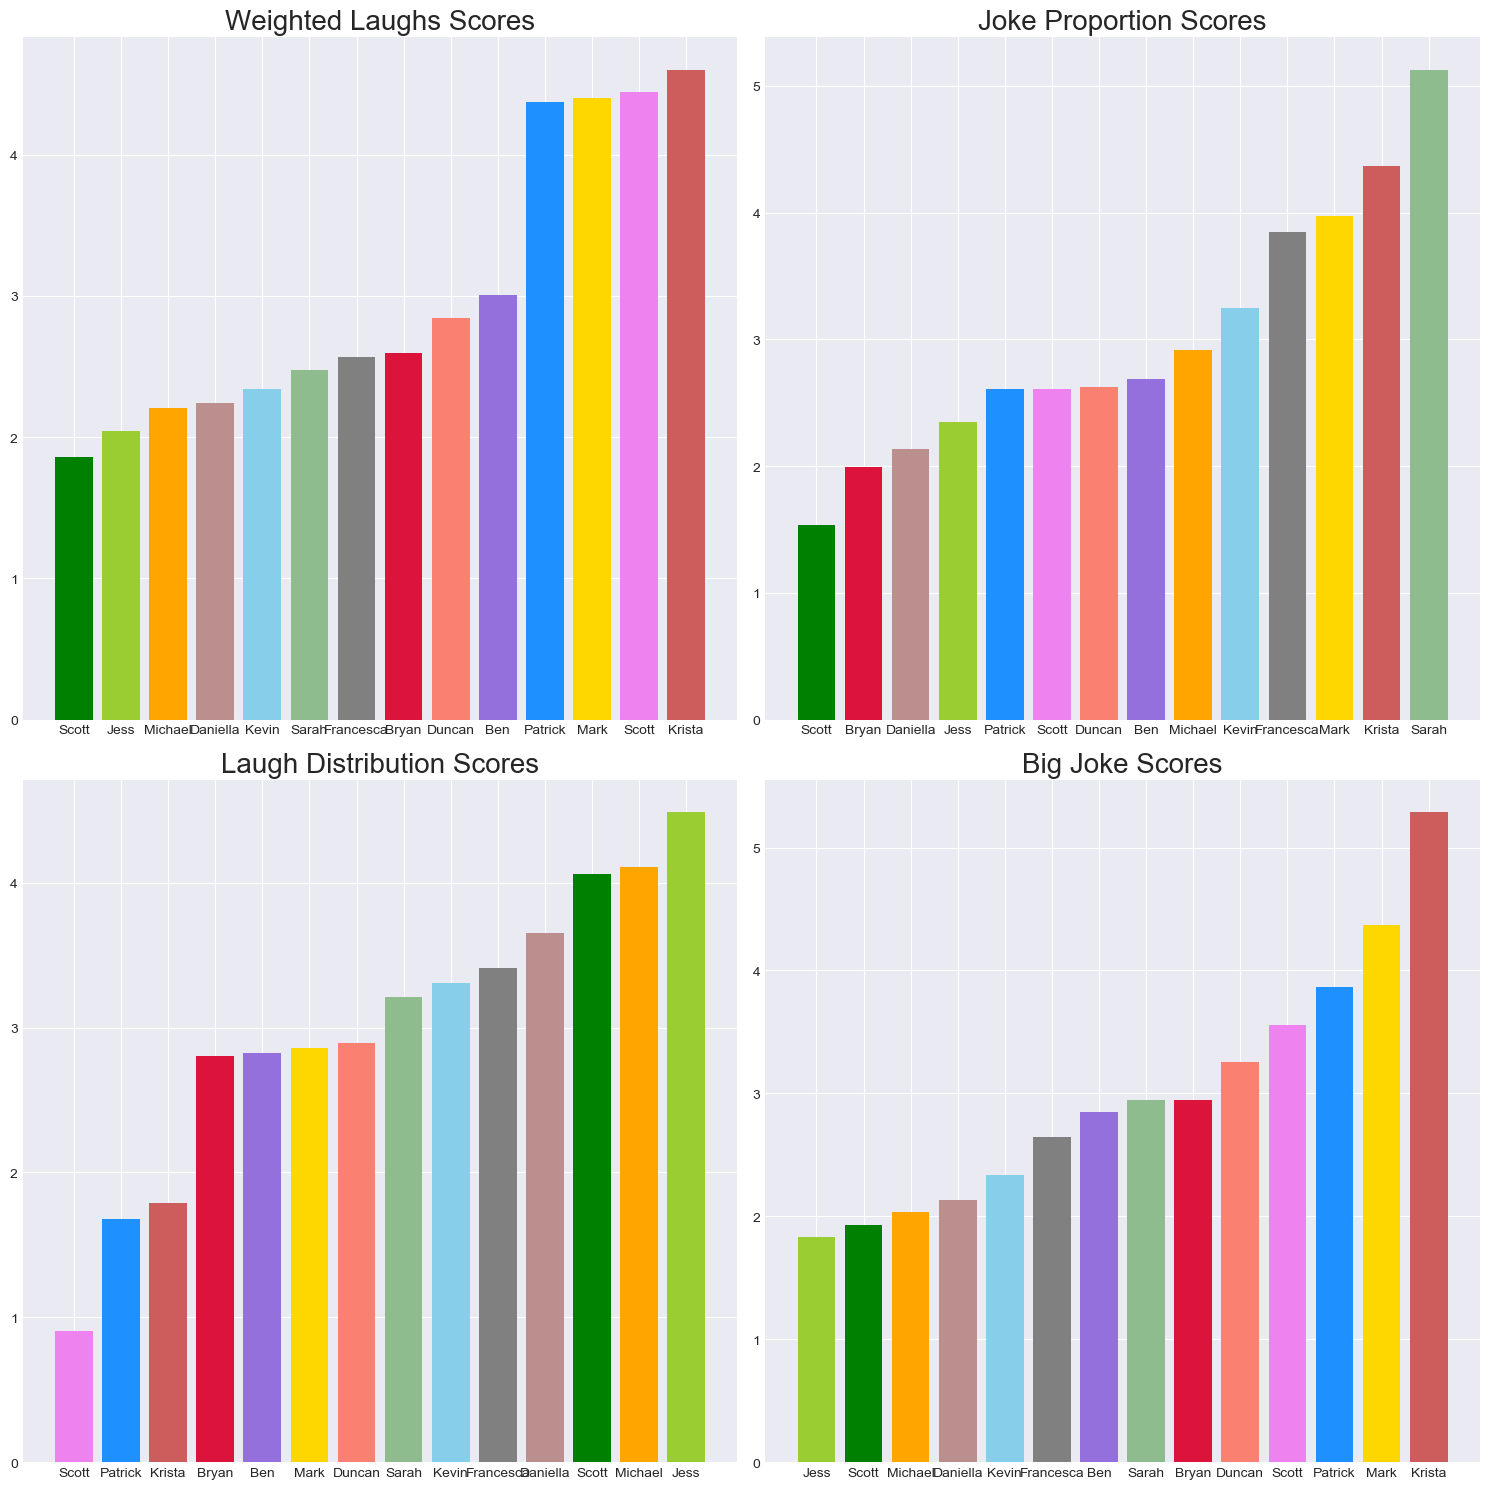

In [6]:
#Chat members ranked by each humor metric

# Initialize the figure style
plt.style.use('seaborn-darkgrid')

names=[]
for joker in Summary.joker:
    names.append(joker.split()[0])
Summary['display_name']=names

#21 colors here, you'll need to add more if there are more participants
#https://matplotlib.org/3.1.0/gallery/color/named_colors.html
colors=['indianred','gold','darkseagreen','dodgerblue','grey','salmon'
        ,'violet','mediumpurple','orange','skyblue','yellowgreen'
       ,'crimson','rosybrown','green','steelblue'
       ,'darkslateblue','hotpink','sandybrown','gold','paleturquoise'
       ,'burlywood','forestgreen','royalblue','khaki']
graph_colors = colors[:Summary.shape[0]]
Summary['color'] = graph_colors


#https://matplotlib.org/gallery/units/bar_demo2.html#sphx-glr-gallery-units-bar-demo2-py
    
values = Summary.weighted_laughs_z_score
spots = np.arange(0, Summary.shape[0], 1)
 
#Summary.reset_index(inplace=True)
weighted_laughs_df = Summary[['index','color','joker','display_name','weighted_laughs_z_score']]
joke_proportion_z_score_df = Summary[['index','color','joker','display_name','joke_proportion_z_score']]
laugh_distribution_z_score_df = Summary[['index','color','joker','display_name','laugh_distribution_z_score']]
big_joke_z_score_df = Summary[['index','color','joker','display_name','big_joke_z_score']]

fig, axs = plt.subplots(2, 2,figsize=(15,15))

weighted_laughs_df.sort_values(by='weighted_laughs_z_score',inplace=True)
axs[0, 0].bar(spots,weighted_laughs_df.weighted_laughs_z_score,tick_label=weighted_laughs_df.display_name,color=weighted_laughs_df.color)
axs[0, 0].set_title('Weighted Laughs Scores',fontsize=20)

joke_proportion_z_score_df.sort_values(by='joke_proportion_z_score',inplace=True)
axs[0, 1].bar(spots,joke_proportion_z_score_df.joke_proportion_z_score,tick_label=joke_proportion_z_score_df.display_name,color=joke_proportion_z_score_df.color)
axs[0, 1].set_title('Joke Proportion Scores',fontsize=20)

laugh_distribution_z_score_df.sort_values(by='laugh_distribution_z_score',inplace=True)
axs[1, 0].bar(spots, laugh_distribution_z_score_df.laugh_distribution_z_score,tick_label=laugh_distribution_z_score_df.display_name,color=laugh_distribution_z_score_df.color)
axs[1, 0].set_title('Laugh Distribution Scores',fontsize=20)

big_joke_z_score_df.sort_values(by='big_joke_z_score',inplace=True)
axs[1, 1].bar(spots, big_joke_z_score_df.big_joke_z_score,tick_label=big_joke_z_score_df.display_name,color=big_joke_z_score_df.color)
axs[1, 1].set_title('Big Joke Scores',fontsize=20)

fig.tight_layout()
plt.show()

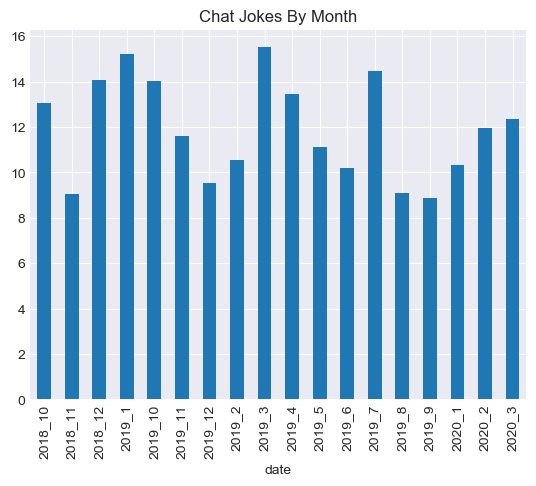

In [7]:
#building some variables to store the date boundaries, and bar chart showing jokes by month

min_year = chat.year.min()
min_month = chat[chat.year == min_year].month.min()
max_year = chat.year.max()
max_month = chat[chat.year == max_year].month.max()

all_months = []
for year in range(int(min_year),int(max_year)+1):
    for month in range(1,13):
        if year == int(min_year):
            if month >= int(min_month):
                all_months.append(str(year) + '_' + str(month))
        elif year == int(max_year):
            if month <= int(max_month):
                all_months.append(str(year) + '_' + str(month))
        else:
            all_months.append(str(year) + '_' + str(month))
                
all_months_df = pd.DataFrame(all_months,columns=['date'])
all_months_df.set_index('date',inplace=True)

chat_counts = pd.DataFrame(chat.year_month.groupby(chat[['month','year','year_month']].year_month).count())
chat_counts.rename(columns={'year_month':'chat count'},inplace=True)

joke_counts_df = pd.DataFrame(jokes_df.date.groupby(jokes_df.year_month).count())
joke_counts_df.rename(columns={'date':'joke count'},inplace=True)

counts_df = pd.merge(all_months_df,chat_counts,left_index=True,right_index=True,how='left')
full_counts = pd.merge(counts_df,joke_counts_df,left_index=True,right_index=True,how='left')
full_counts['joke_prop'] = full_counts['chat count'] / full_counts['joke count']
full_counts.joke_prop.groupby(full_counts.index).sum().plot(kind='bar')

plt.title('Chat Jokes By Month')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


Text(0.5,1,'Monthly Composite Humor Scores')

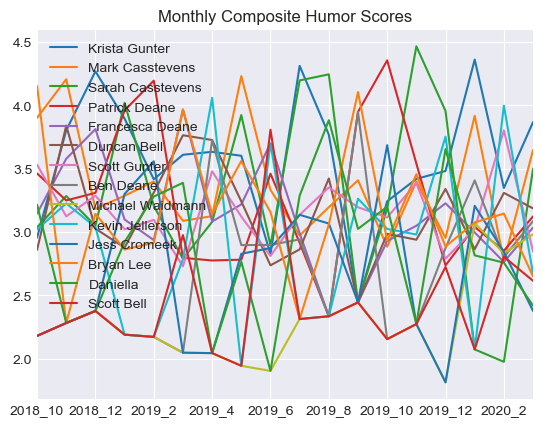

In [8]:
#calculating monthly composite humor scores
all_summaries = []
n=0
for date in list(full_counts.index):
    #if date in list(jokes_df.year_month.drop_duplicates()): #use this to exclude any months without ANY chats
    df = jokes_df[jokes_df.year_month == date]

    #now creating summary figures to assess jokers
    joker_counts = pd.DataFrame(df.joker.value_counts())
    laugher_counts = pd.DataFrame(df.laugher.value_counts())
    full_chat_counts = pd.DataFrame(chat[chat.year_month == date].UserName.value_counts())
    full_chat_counts.rename(columns={"UserName": "full_chat_count"},inplace=True)

    joker_weights = df.groupby(by=['joker']).agg({'laugh_weight': 'sum'})

    m_Summary = pd.concat([joker_counts,laugher_counts,full_chat_counts,joker_weights],axis=1)
    m_Summary.rename(columns={'joker':'joke_count','index':'joker','laugher':'laugh_count'},inplace=True)
    m_Summary.reset_index(inplace=True)
    m_Summary.rename(columns={'index':'joker'},inplace=True)

    #handle case where joker does not show up in given month
    for user in list(chat.UserName.drop_duplicates()):
        if user not in list(m_Summary.joker):
            m_Summary = pd.concat([m_Summary,pd.DataFrame({'joker':[user],
                                         'joke_count':[0],
                                         'laugh_count':[0],
                                         'full_chat_count':[0],
                                         'laugh_weight':[0]})])
    m_Summary.reset_index(inplace=True) #handle new records added with index of 0
    m_Summary.drop('index',axis=1,inplace=True)
    m_Summary = m_Summary.fillna(0) #replace any NaNs with 0

    m_Summary['joke_proportion'] = m_Summary.joke_count / (m_Summary.full_chat_count - m_Summary.laugh_count)
    m_Summary = m_Summary.fillna(0) #replace any NaNs with 0

    #we will use this to assess joke distribution among chatters, could also be used as a composite metric as well
    joke_count_z_scores = []
    for joker,i in zip(m_Summary.joker, list(range(m_Summary.shape[0]))):
        joke_count_z_scores.append((m_Summary[m_Summary.joker == joker].joke_count[i] - m_Summary.joke_count.mean()) / float(m_Summary.joke_count.std()))
    m_Summary['joke_count_z_score'] = joke_count_z_scores

    #building a feature which describes "how spread out the laugher is" among chatters
    laugher_proportions = []
    for joker in df.joker.drop_duplicates():
        for laugher in df.laugher.drop_duplicates():
            if laugher != joker:
                laugher_proportions.append((joker,laugher,df[(df.joker == joker) & (df.laugher == laugher)].shape[0]\
                                               / df[df.laugher == laugher].shape[0]))

    m_laugher_proportions_df = pd.DataFrame(data=laugher_proportions,columns=['joker','laugher','laugher_proportion'])
    m_laugher_proportions_df.sort_values(by=['joker','laugher_proportion'], ascending=False)

    from statistics import mean

    laugh_distribution_scores = []
    for joker in m_Summary.joker:
        laugher_distribution_z_scores =[]
        for laugher in m_laugher_proportions_df.laugher.drop_duplicates():
            if joker in list(m_laugher_proportions_df.joker) and joker != laugher:
                #this is a score to indicate a laugher's laughs for given joker relative to the number of laughs for given laugher
                #point is to get at whether a joker is getting laughs from everyone or just a small number of people
                try:
                    laugher_distribution_z_scores.append((list(m_laugher_proportions_df[(m_laugher_proportions_df.joker == joker) & (m_laugher_proportions_df.laugher == laugher)].laugher_proportion)[0]\
                                                    - m_laugher_proportions_df[m_laugher_proportions_df.laugher == laugher].laugher_proportion.mean())\
                                                    / float(m_laugher_proportions_df[m_laugher_proportions_df.laugher == laugher].laugher_proportion.std()))
                except:
                    laugher_distribution_z_scores.append(0)
        if len(laugher_distribution_z_scores) >0:
            comparison_scores = []
            for value in laugher_distribution_z_scores:
                #we compare the joke count z score to these laugher distribution scores and then take mean
                comparison_scores.append((value + 3) - (list(m_Summary[m_Summary.joker == joker].joke_count_z_score)[0] + 3))
            laugh_distribution_scores.append(mean(comparison_scores)+1)
        else:
            laugh_distribution_scores.append(0)

    m_Summary['laugh_distribution_score'] = laugh_distribution_scores

    #creating a metric to credit jokers who make multiple people laugh
    big_joke_counts = []
    for joker in m_Summary.joker:
        joker_df = df[df.joker == joker]
        joker_df_counts = pd.DataFrame(joker_df.joke_message.value_counts())
        big_joke_counts.append(joker_df_counts[joker_df_counts.joke_message >= 2].shape[0]) #count number of jokes having at least 2 laughs
    m_Summary['big_joke_count'] = big_joke_counts

    #creating the z scores that we'll use for composite score

    weighted_laughs_z_scores = []
    for value in m_Summary.laugh_weight:
        try:
            weighted_laughs_z_scores.append(((value - m_Summary.laugh_weight.mean()) / m_Summary.laugh_weight.std())+3)
        except:
            weighted_laughs_z_scores.append(0)

    m_Summary['weighted_laughs_z_score'] = weighted_laughs_z_scores

    joke_proportion_z_scores = []
    for value in m_Summary.joke_proportion:
        try:
            joke_proportion_z_scores.append(((value - m_Summary.joke_proportion.mean()) / m_Summary.joke_proportion.std())+3)
        except:
            joke_proportion_z_scores.append(0)

    m_Summary['joke_proportion_z_score'] = joke_proportion_z_scores

    laugh_distribution_z_scores = []
    for value in m_Summary.laugh_distribution_score:
        try:
            laugh_distribution_z_scores.append(((value - m_Summary.laugh_distribution_score.mean()) / m_Summary.laugh_distribution_score.std())+3)
        except:
            laugh_distribution_z_scores.append(0)

    m_Summary['laugh_distribution_z_score'] = laugh_distribution_z_scores

    big_joke_z_scores = []
    for value in m_Summary.big_joke_count:
        try:
            big_joke_z_scores.append(((value - m_Summary.big_joke_count.mean()) / m_Summary.big_joke_count.std())+3)
        except:
            big_joke_z_scores.append(0)

    m_Summary['big_joke_z_score'] = big_joke_z_scores

    m_Summary['composite_humor_score'] = (m_Summary['weighted_laughs_z_score'] + m_Summary['big_joke_z_score'] + m_Summary['joke_proportion_z_score'] + m_Summary['laugh_distribution_z_score']) / 4
    m_Summary['year_month'] = date
    all_summaries.append(m_Summary)

monthly_summaries_df = pd.concat(all_summaries)
monthly_summaries_df.reset_index(inplace=True)
monthly_summaries_df[['year','month']] = monthly_summaries_df.year_month.str.split('_',expand=True)
monthly_summaries_df['year'] = monthly_summaries_df['year'].astype(int)
monthly_summaries_df['month'] = monthly_summaries_df['month'].astype(int)
#print('monthly summaries compiled')

monthly_scores_df = pd.DataFrame(index=list(full_counts.index))

for user in Summary.joker.drop_duplicates():
    monthly_scores_df[user] = list(monthly_summaries_df[monthly_summaries_df.joker == user].composite_humor_score)
    
monthly_scores_df.plot.line()
plt.title('Monthly Composite Humor Scores')

Text(0.5,1,'Monthly Composite Humor Scores')

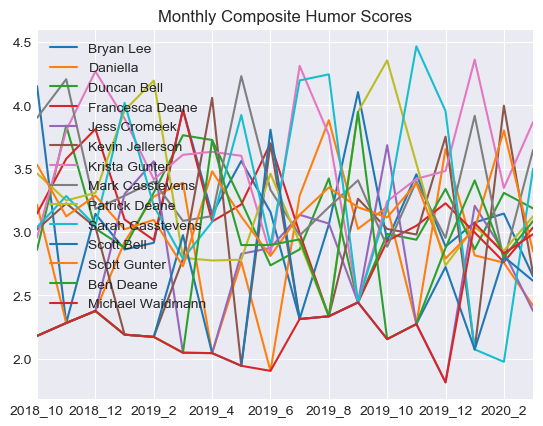

In [9]:
#pulling only chats where there are consistent chats over time period, avoiding gaps of nonactivity
contiguous_months=monthly_summaries_df[(monthly_summaries_df.year==2018) & (monthly_summaries_df.month >=7) | (monthly_summaries_df.year>=2019)]

monthly_scores_df = pd.DataFrame(index=list(contiguous_months.year_month.drop_duplicates()))

for user in contiguous_months.joker.drop_duplicates():
    monthly_scores_df[user] = list(contiguous_months[monthly_summaries_df.joker == user].composite_humor_score)
    
monthly_scores_df.plot.line()
plt.title('Monthly Composite Humor Scores')

Text(0,0.5,'Monthly Humor Score')

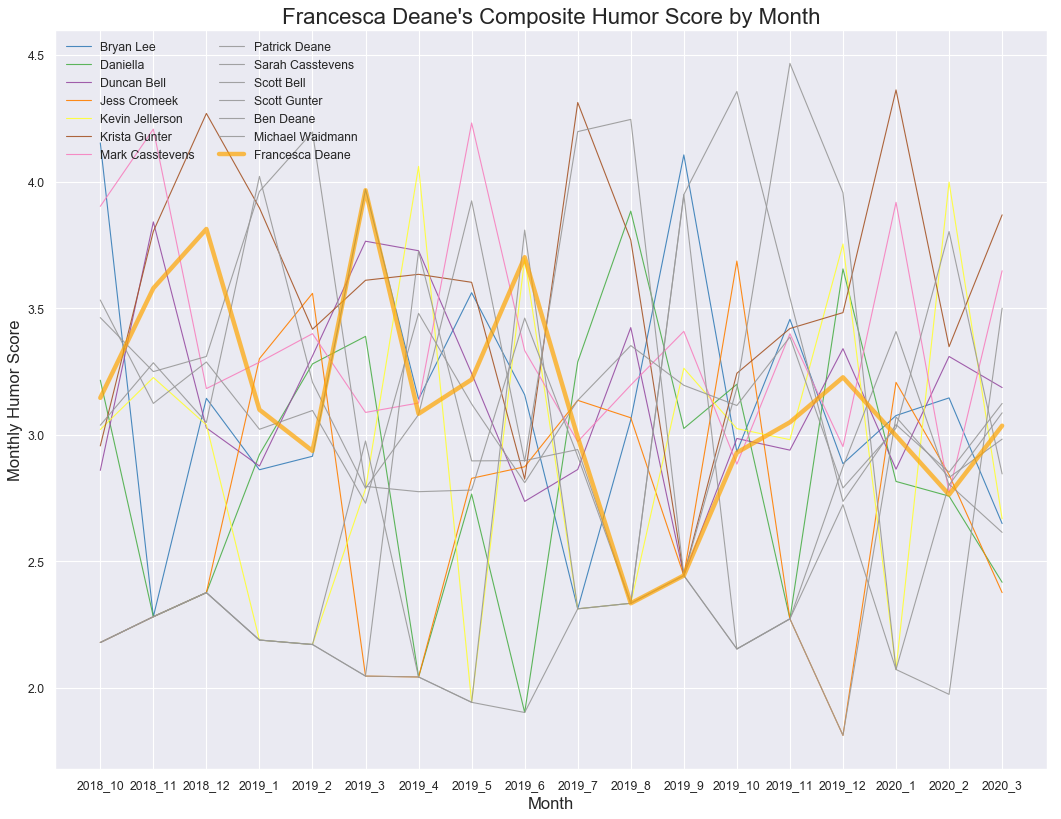

In [18]:
###########################
joker = 'Francesca Deane' ###change this to the joker you want to highlight
###########################

# style
#plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')

from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
 
# multiple line plot
num=0
non_highlight_cols = list(monthly_scores_df.columns)
non_highlight_cols.remove(joker)
for column in non_highlight_cols:
    num= num+1
    plt.plot(monthly_scores_df.index, monthly_scores_df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)


#highlight one joker
plt.plot(monthly_scores_df.index, monthly_scores_df[joker], marker='', color='orange', linewidth=4, alpha=0.7)

# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title(joker + "'s Composite Humor Score by Month", fontsize=20, fontweight=10,)
plt.xlabel("Month",fontsize=15)
plt.ylabel("Monthly Humor Score",fontsize=15)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1.02,'Monthly Composite Humor Score, Top 9 Jokers')

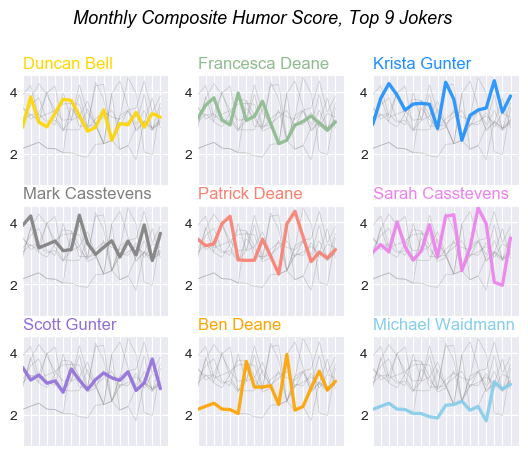

In [11]:
#reducing down to top 9 funny chatters for this visual
monthly_scores_df9=monthly_scores_df.copy()
for col in monthly_scores_df9.columns:
    if col not in list(Summary.joker.head(9)):
        monthly_scores_df9.drop(col,axis=1,inplace=True)

# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
#plt.rcParams['figure.figsize'] = (5, 3)

# create a color palette
#palette = plt.get_cmap('Set1_r')

if monthly_scores_df9.shape[1] <=4:
    plots=2
else:
    plots=3

# multiple line plot
num=0
for column in monthly_scores_df9:
    num+=1
 
    # Find the right spot on the plot based on num
    plt.subplot(plots,plots, num) #you could use this to adjust the number of concurrent graphs
    
    #I can't figure out how to increase the size of these plots
    #plt.figure(num, figsize=(16,12))
 
    # plot every groups, but discreet
    for v in monthly_scores_df9:
        plt.plot(monthly_scores_df9.index, monthly_scores_df9[v], marker='', color='grey', linewidth=0.6, alpha=0.3)
 
    #plt.subplots(figsize=(12, 6))
    # Plot the lineplot
    plt.plot(monthly_scores_df9.index, monthly_scores_df9[column], marker='', color=colors[num], linewidth=2.4, alpha=0.9, label=column)
 
    # Same limits for everybody!
    plt.xlim(0,monthly_scores_df9.shape[0])
    plt.ylim(1,4.5)
 
    plt.tick_params(labelbottom='off')
    '''# Not ticks everywhere
    if num in range(7) :
        plt.tick_params(labelbottom='off')
    if num not in [1,4,7] :
        plt.tick_params(labelleft='off')
 '''
    # Add title
    plt.title(column, loc='left', fontsize=12, fontweight=0, color=colors[num] )

# general title
plt.suptitle("Monthly Composite Humor Score, Top 9 Jokers", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
 
# Axis title
#plt.text(0.5, 0.02, 'Time', ha='center', va='center')
#plt.text(0.06, 0.5, 'Note', ha='center', va='center', rotation='vertical')


In [19]:
#jokes from funniest month for specific joker
joker = 'Sarah Casstevens'
funniest_month = monthly_scores_df.sort_values(by=[joker],axis=0,ascending=False)[joker].index[0]
jokes_df[(jokes_df.joker==joker) & (jokes_df.year_month==funniest_month)]

,date,year_month,joker,joke_message,laugher,laugh_message,laugh_weight
704,11/22/2019,2019_11,Sarah Casstevens,Or maybe Kris can accidentally throw a hose on...,Mark Casstevens,😂,1.5
705,11/22/2019,2019_11,Sarah Casstevens,Or maybe Kris can accidentally throw a hose on...,Krista Gunter,Lmao,1.5
706,11/22/2019,2019_11,Sarah Casstevens,Or maybe Kris can accidentally throw a hose on...,Scott Gunter,Hahahaha,2.0


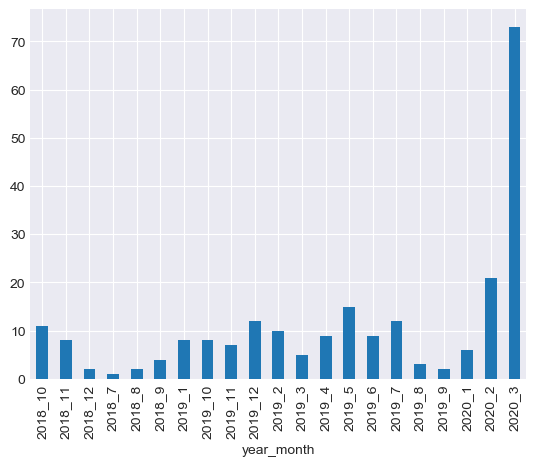

In [13]:
jokes_df[jokes_df.joker == 'Scott Gunter'].year_month.groupby(jokes_df.year_month).count().plot(kind='bar')

Text(0.5,1,'Example of laugh distribution')

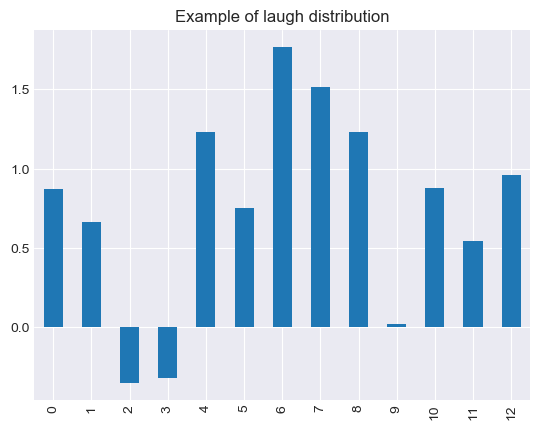

In [14]:
#visualization to illustrate how we are calculating the laugher_distribution_score
laugher_distribution_full_df['softened_comparison_score'] = laugher_distribution_full_df.comparison_score+1
laugher_distribution_full_df[laugher_distribution_full_df.joker == Summary.joker[0]].softened_comparison_score.plot.bar()
plt.title('Example of laugh distribution')

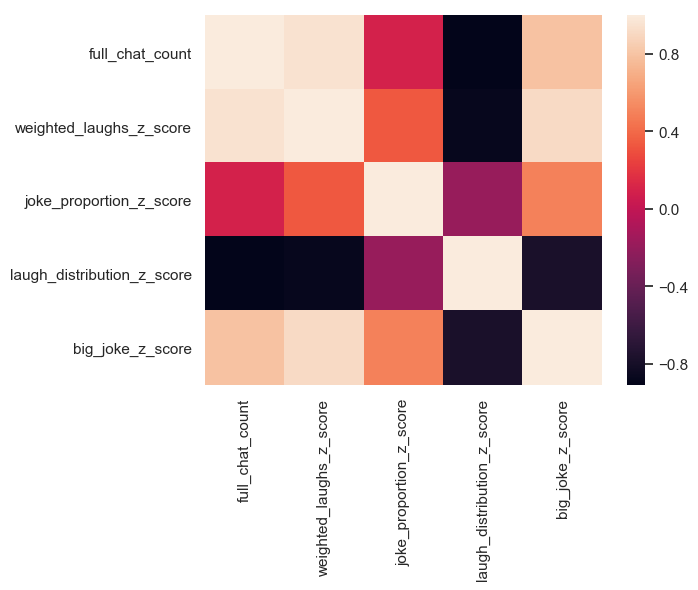

In [15]:
import seaborn as sns; sns.set()
sns.heatmap(Summary[['full_chat_count','weighted_laughs_z_score','joke_proportion_z_score','laugh_distribution_z_score','big_joke_z_score']].corr())

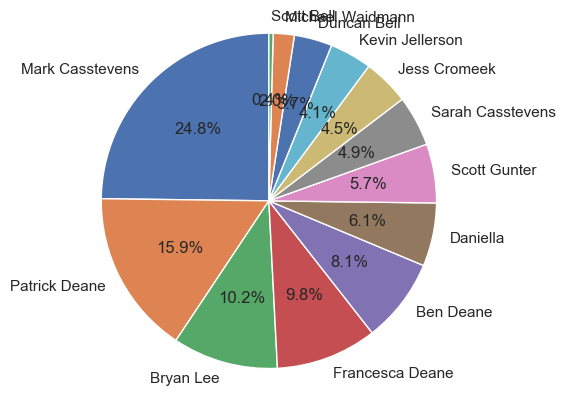

In [16]:
joker = Summary.joker[0]
jokers = jokes_df[jokes_df.joker == joker].laugher.value_counts().index
values = jokes_df[jokes_df.joker == joker].laugher.value_counts().values
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=jokers, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [17]:
#NEED TO SUPPRESS THESE
jokes_df[jokes_df.joker == jokes_df.laugher]

,date,year_month,joker,joke_message,laugher,laugh_message,laugh_weight
526,6/30/2019,2019_6,Scott Gunter,True story- mark asked me to be his +1 to her ...,Scott Gunter,I also left mark there lol,1.0
699,11/22/2019,2019_11,Scott Gunter,Pat?,Scott Gunter,Hahaha turf,1.5
819,1/17/2020,2020_1,Ben Deane,Always tho,Ben Deane,Hahahahaha,2.0
1016,3/6/2020,2020_3,Ben Deane,Need Leto prove yourself,Ben Deane,Lol. Need Leto = gotta,1.0
1319,3/19/2020,2020_3,Ben Deane,Some of these hotel companies won’t make it th...,Ben Deane,Hahahaha,2.0
